##### Modules

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

import numpy as np
from data_handler import DataHandler
from droplet_model import DropletModel, ReparameterisedDropletModel, DropletModelUnknownInitialConditions
from parameter_fitting import ParameterFitting
from plots import Plots
import matplotlib.pyplot as plt
import pints
import pints.plot
from scipy.integrate import odeint
from numba import njit
import seaborn as sns
from cycler import cycle

plotter = Plots()

##### Functions and Methods

In [39]:
def plot_mle_solution(
    model, 
    data,
    data_times,
    param_mles,
    sigma_mles,
    z_value = 1.96,
    max_size_shown=None,
    fig_size=(8,5),
    noise_model="additive normal"
):
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    model_params = param_mles


    num_model_times = 200
    model_times = np.linspace(4, 14, num_model_times)

    num_outputs = model.n_outputs()
    if max_size_shown is None:
        max_size_shown = num_outputs
    
    opt_model_sol = model.simulate(params=model_params, times=model_times)


    palette = sns.color_palette("Set1", n_colors=max_size_shown)
    colour_cycle = cycle(palette)

    for n in range(max_size_shown):

        opt_model_sol_n = opt_model_sol[:, n]

        if noise_model == "additive normal":
            model_lower = opt_model_sol_n - z_value * sigma_mles[n]
            model_upper = opt_model_sol_n + z_value * sigma_mles[n]
        elif noise_model == "multiplicative normal":
            model_lower = opt_model_sol_n * (1 - z_value * sigma_mles[n]) 
            model_upper = opt_model_sol_n * (1+ z_value * sigma_mles[n])
        elif noise_model == "lognormal":
            model_lower = opt_model_sol_n * np.exp(- z_value * sigma_mles[n])
            model_upper = opt_model_sol_n * np.exp(z_value * sigma_mles[n])
        else:
            raise ValueError("noise model not valid")


        plot_colour = next(colour_cycle)
        ax.plot(data_times, data[:, n], marker='s', markersize=10, markeredgecolor='k', linestyle='--', label='data', c=plot_colour)
        ax.plot(model_times, opt_model_sol_n, linewidth=4, label='model', c=plot_colour)
        ax.fill_between(model_times,model_lower,model_upper,color=plot_colour,alpha=0.1,label=f'95% CI')

    ax.set_xlabel(r'$t$ (days)')
    ax.set_ylabel(r'$\phi_n(t)$')
    plt.show()



def generate_synthetic_data(
    model,
    model_params,
    data_times,
    sigma_values,
    noise_factor=None,
    noise_model="additive normal",
    rng=None
):
    
    model_sol = model.simulate(model_params, data_times)
    N = model.n_outputs()
    T = len(data_times)


    if sigma_values is None:

        sigma_values = noise_factor * np.std(model_sol, axis=0)

    if rng is None:
        rng = np.random.default_rng()

    eps = rng.normal(loc=0.0, scale=sigma_values.reshape(1, N), size=(T, N))

    if noise_model == "additive normal":

        synthetic_prediction = model_sol + eps
        
    elif noise_model == "multiplicative normal":

        synthetic_prediction = model_sol * (1 + eps)

    elif noise_model == "lognormal":

        synthetic_prediction = model_sol * np.exp(eps)

    return sigma_values, synthetic_prediction



def get_sigma_MLEs(
    model, 
    data, 
    mle_params, 
    data_times, 
    noise_model="additive normal"
):

    opt_model_sol = model.simulate(mle_params, data_times)
    residuals = opt_model_sol - data

    n_t = len(data_times)

    if noise_model == "additive normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2, axis=0))

    elif noise_model == "multiplicative normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2 / opt_model_sol, axis=0))

    elif noise_model == "lognormal":

        log_residuals = np.log(data) - np.log(opt_model_sol)

        log_residuals = np.nan_to_num(log_residuals, nan=0)

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(log_residuals**2, axis=0))

    return sigma_MLEs



def get_opt_parameters(
    log_likelihood,
    opt_lower_bounds,
    opt_upper_bounds,
    log_transform_opt=True,
    opt_method=pints.CMAES,
    opt_initial_position=None,
    display_log=True
):
    
    opt_bounds = pints.RectangularBoundaries(opt_lower_bounds, opt_upper_bounds)
    log_prior = pints.UniformLogPrior(opt_bounds)

    if opt_initial_position is None:
        opt_initial_position = log_prior.sample(1)

    if log_transform_opt:
        transformation = pints.LogTransformation(n_parameters=3)
    else:
        transformation = None

    opt = pints.OptimisationController(
        log_likelihood, 
        opt_initial_position, 
        boundaries=opt_bounds, 
        method=pints.CMAES,
        transformation=transformation
    )

    opt.set_log_to_screen(display_log)
    opt_params, opt_max_likelihood = opt.run()

    return opt_params



def get_mcmc_chains(
    log_likelihood,
    apply_log_transform = False,
    mcmc_method = pints.HaarioBardenetACMC,
    max_mcmc_iterations = 30000,
    num_chains = 4,
    prior_lower_bounds = [1e1, 1e-10, 1e-2],
    prior_upper_bounds = [1e4, 1e0, 1e1],
    specified_log_prior=None,
    initial_mcmc_points=None,
    log_to_screen=True
):

    if specified_log_prior is None:
        
        prior_bounds = pints.RectangularBoundaries(prior_lower_bounds, prior_upper_bounds)
        log_prior = pints.UniformLogPrior(prior_bounds)

    else:

        log_prior = specified_log_prior


    if initial_mcmc_points is None:
        initial_mcmc_points = log_prior.sample(num_chains)


    mcmc_transform = None
    if apply_log_transform:

        mcmc_transform = pints.LogTransformation(n_parameters=log_likelihood._n_parameters)

    log_posterior = pints.LogPosterior(log_likelihood, log_prior)

    mcmc = pints.MCMCController(log_posterior, num_chains, initial_mcmc_points, method=mcmc_method, transformation=mcmc_transform)
    mcmc.set_max_iterations(max_mcmc_iterations)
    # mcmc.set_parallel(True)
    mcmc.set_log_to_screen(log_to_screen)

    chains = mcmc.run()

    return chains



def get_standardised_residuals(
    model,
    data,
    data_times,
    mle_params,
    noise_model
):
    
    model_sol = model.simulate(mle_params, data_times)

    sigma_mles = get_sigma_MLEs(
        model=model,
        data=data,
        mle_params=mle_params,
        data_times=data_times,
        noise_model=noise_model
    )

    if noise_model == "additive normal":

        residuals = data - model_sol
        std_residuals = residuals / sigma_mles
        
    elif noise_model == "multiplicative normal":

        residuals = (data - model_sol) / model_sol
        std_residuals = residuals / sigma_mles

    elif noise_model == "lognormal":

        residuals = np.log(data) - np.log(model_sol)
        std_residuals = residuals / sigma_mles

    return std_residuals

##### Log-likelihoods

In [3]:
class AdditivenormalLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, use_profile=True, eps=1e-12, mask_threshold=0.0):
        super(AdditivenormalLogLikelihood, self).__init__(problem)

        # Get number of times, number of outputs
        self._nt = len(self._times)
        self._no = problem.n_outputs()

        # Add parameters to problem

        self.use_profile = use_profile

        if self.use_profile:
            self._n_parameters = problem.n_parameters()
        else:
            self._n_parameters = problem.n_parameters() + self._no

        self._eps = eps
        self._mask_threshold = mask_threshold

        # Pre-calculate parts

        # For a log-normal sampling distribution any data points being below
        # zero would mean that the log-likelihood is always -infinity
        # Boolean mask: True for columns with NO zeros

        vals = self._values

        mask = np.all(vals > self._mask_threshold, axis=0)

        # Indices of size classes kept
        kept_indices = np.where(mask)[0]

        # New vals array with only those size classes
        self.values_filtered = vals[:, mask]

        self._no_filtered = self.values_filtered.shape[1]



    def __call__(self, x):

        sigmas = np.asarray(x[-self._no:])

        if self.use_profile:

            soln = self._problem.evaluate(x[:-self._no])

        else:

            soln = self._problem.evaluate(x)

        ll = 0.0

        for i in range(0, self._no_filtered):

            model_n = soln[:, i]
            data_n = self.values_filtered[:, i]

            res = (data_n - model_n + self._eps)**2

            if self.use_profile:

                sigma_n = np.sqrt((1 / self._nt) * np.sum(res))

            else:

                sigma_n = sigmas[i]

            term1 = -0.5 * self._nt * np.log(2 * np.pi)

            term2 = -0.5 * self._nt * np.log(sigma_n**2 + self._eps)

            term3 = -0.5 * self._nt

            ll_n = term1 + term2 + term3

            # print(f"n = {i+1}, ll_n = {ll_n}")

            ll += ll_n

        return ll



class MultiplicativenormalLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, use_profile=True, eps=1e-12, mask_threshold=0.0):
        super(MultiplicativenormalLogLikelihood, self).__init__(problem)

        # Get number of times, number of outputs
        self._nt = len(self._times)
        self._no = problem.n_outputs()

        self.use_profile = use_profile

        if self.use_profile:
            self._n_parameters = problem.n_parameters()
        else:
            self._n_parameters = problem.n_parameters() + self._no

        self._eps = eps
        self._mask_threshold = mask_threshold

        # Pre-calculate parts

        # For a log-normal sampling distribution any data points being below
        # zero would mean that the log-likelihood is always -infinity
        # Boolean mask: True for columns with NO zeros

        vals = self._values

        mask = np.all(vals > self._mask_threshold, axis=0)

        # Indices of size classes kept
        kept_indices = np.where(mask)[0]

        # New vals array with only those size classes
        self.values_filtered = vals[:, mask]

        self._no_filtered = self.values_filtered.shape[1]



    def __call__(self, x):

        sigmas = np.asarray(x[-self._no:])

        if self.use_profile:

            soln = self._problem.evaluate(x[:-self._no])

        else:

            soln = self._problem.evaluate(x)

        ll = 0.0

        for i in range(0, self._no_filtered):

            model_n = soln[:, i]
            data_n = self.values_filtered[:, i]

            res = (data_n - model_n + self._eps)**2 / (model_n + self._eps)**2

            if self.use_profile:

                sigma_n = np.sqrt((1 / self._nt) * np.sum(res))

            else:

                sigma_n = sigmas[i]

            term1 = -0.5 * self._nt * np.log(2 * np.pi)

            term2 = -0.5 * self._nt * np.log(sigma_n**2 + self._eps)

            term3 = -0.5 * np.sum(np.log(model_n**2 + self._eps))

            term4 = -0.5 * self._nt

            ll_n = term1 + term2 + term3 + term4

            # print(f"n = {i+1}, ll_n = {ll_n}")

            ll += ll_n

        return ll
    


class LognormalLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, use_profile=True, eps=1e-12, mask_threshold=0.0):
        super(LognormalLogLikelihood, self).__init__(problem)

        # Get number of times, number of outputs
        self._nt = len(self._times)
        self._no = problem.n_outputs()

        self.use_profile = use_profile

        if self.use_profile:
            self._n_parameters = problem.n_parameters()
        else:
            self._n_parameters = problem.n_parameters() + self._no

        self._eps = eps
        self._mask_threshold = mask_threshold

        # Pre-calculate parts

        # For a log-normal sampling distribution any data points being below
        # zero would mean that the log-likelihood is always -infinity
        # Boolean mask: True for columns with NO zeros

        vals = self._values

        mask = np.all(vals > self._mask_threshold, axis=0)

        # Indices of size classes kept
        kept_indices = np.where(mask)[0]

        # New vals array with only those size classes
        self.values_filtered = vals[:, mask]

        self._no_filtered = self.values_filtered.shape[1]



    def __call__(self, x):

        sigmas = np.asarray(x[-self._no:])

        if self.use_profile:

            soln = self._problem.evaluate(x[:-self._no])

        else:

            soln = self._problem.evaluate(x)

        ll = 0.0

        for i in range(0, self._no_filtered):

            model_n = soln[:, i]
            data_n = self.values_filtered[:, i]

            log_res = (np.log(data_n + self._eps) - np.log(model_n + self._eps))**2

            if self.use_profile:

                sigma_n = np.sqrt((1 / self._nt) * np.sum(log_res))

            else:

                sigma_n = sigmas[i]

            term1 = -0.5 * self._nt * np.log(2 * np.pi)

            term2 = -0.5 * self._nt * np.log(sigma_n**2 + self._eps)

            term3 = -0.5 * np.sum(np.log(data_n**2 + self._eps))

            term4 = -0.5 * self._nt

            ll_n = term1 + term2 + term3 + term4

            # print(f"n = {i+1}, ll_n = {ll_n}")

            ll += ll_n

        return ll



def get_log_likelihood(
    problem,
    noise_model,
    use_profile=True,
    mask_threshold=1        
):


    if noise_model == "additive normal":

        log_likelihood = AdditivenormalLogLikelihood(
            problem=problem,
            use_profile=use_profile,
            mask_threshold=mask_threshold
        )

    elif noise_model == "multiplicative normal":

        log_likelihood = MultiplicativenormalLogLikelihood(
            problem=problem,
            use_profile=use_profile,
            mask_threshold=mask_threshold
        )

    elif noise_model == "lognormal":

        log_likelihood = LognormalLogLikelihood(
            problem=problem,
            use_profile=use_profile,
            mask_threshold=mask_threshold
        )

    else:

        raise ValueError(f"Noise model, {noise_model}, is not a valid nosie model!")





    return log_likelihood

## Introduction

##### Choose the noise model

In [4]:
noise_models = [
    "additive normal",
    "multiplicative normal",
    "lognormal"
]

noise_model = noise_models[0]

## Synthetic data testing

##### Hyperparameters

In [5]:
synthetic_model_params = np.asarray([3e3, 3e-5, 2e-1])
noise_factor = 0.0

##### Generate synthetic data

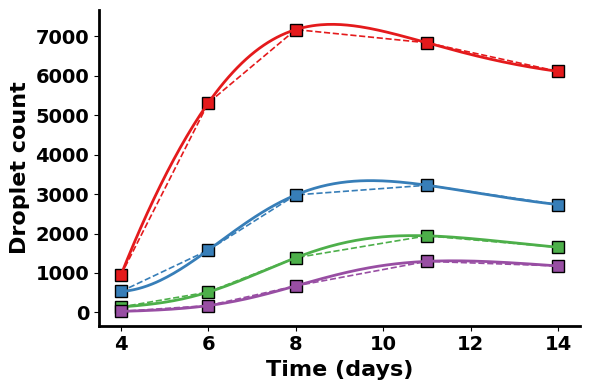

In [6]:
data_handler = DataHandler()
ntc_ics = data_handler.get_gene_average_array(pool_id=1, gene_id="NTC (avg)", max_bin_number=51)[0]

synthetic_initial_conditions = ntc_ics

synthetic_model = DropletModel(initial_conditions=synthetic_initial_conditions)
data_times = [4,6,8,11,14]

model_times = np.linspace(4,14,200)
synthetic_true_model_sol = synthetic_model.simulate(params=synthetic_model_params, times=model_times)

synthetic_sigma_values, synthetic_data = generate_synthetic_data(
    model=synthetic_model,
    model_params=synthetic_model_params,
    data_times=data_times,
    sigma_values=None,
    noise_factor=noise_factor,
    noise_model=noise_model
)
synthetic_problem = pints.MultiOutputProblem(synthetic_model, data_times, synthetic_data)

plotter.plot_data_and_model_timecourse(
    model_sol=synthetic_true_model_sol,
    data_array=synthetic_data,
    fig_size=(6,4)
)

##### Use optimisation to get MLEs

In [7]:
synthetic_log_likelihood = get_log_likelihood(
    problem=synthetic_problem,
    noise_model=noise_model,
    mask_threshold=1
)

opt_lower_bounds = np.asarray([1e1, 1e-10, 1e-2])
opt_upper_bounds = np.asarray([1e4, 1e-3, 1e0])

synthetic_opt_params = get_opt_parameters(
    log_likelihood=synthetic_log_likelihood,
    opt_lower_bounds=opt_lower_bounds,
    opt_upper_bounds=opt_upper_bounds,
    log_transform_opt=True,
    display_log=False
)

print(f"True parameters: {synthetic_model_params}")
print(f"Estimated parameters: {synthetic_opt_params}")

True parameters: [3.e+03 3.e-05 2.e-01]
Estimated parameters: [3.e+03 3.e-05 2.e-01]


## Experimental data test fitting

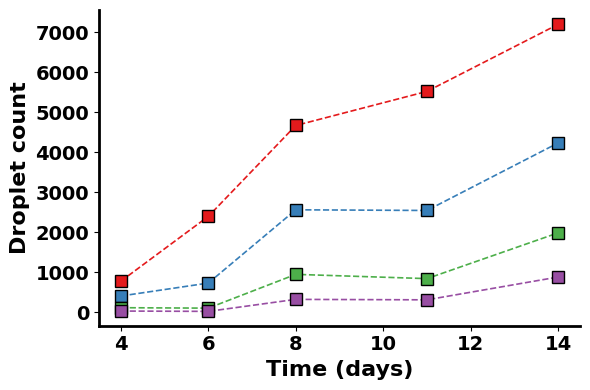

In [55]:
data_array = data_handler.get_gene_average_array(pool_id=1, gene_id="IRS-1", max_bin_number=51)
data_initial_conditions = data_array[0]

plotter.plot_data_and_model_timecourse(
    model_sol=None,
    data_array=data_array,
    fig_size=(6,4)
)

data_model = DropletModel(initial_conditions=data_initial_conditions)

data_problem = pints.MultiOutputProblem(data_model, data_times, data_array)


##### Use optimisation to get MLEs

In [58]:
data_log_likelihood = get_log_likelihood(
    problem=data_problem,
    noise_model=noise_model,
    mask_threshold=1
)

opt_lower_bounds = np.asarray([1e1, 1e-10, 1e-4])
opt_upper_bounds = np.asarray([1e4, 1e-3, 1e0])

data_opt_params = get_opt_parameters(
    log_likelihood=data_log_likelihood,
    opt_lower_bounds=opt_lower_bounds,
    opt_upper_bounds=opt_upper_bounds,
    log_transform_opt=True,
    display_log=False
)

print(f"Estimated parameters: {data_opt_params}")

Estimated parameters: [1.35064709e+03 6.58869868e-06 1.35106066e-01]


##### Predicted MLE solution

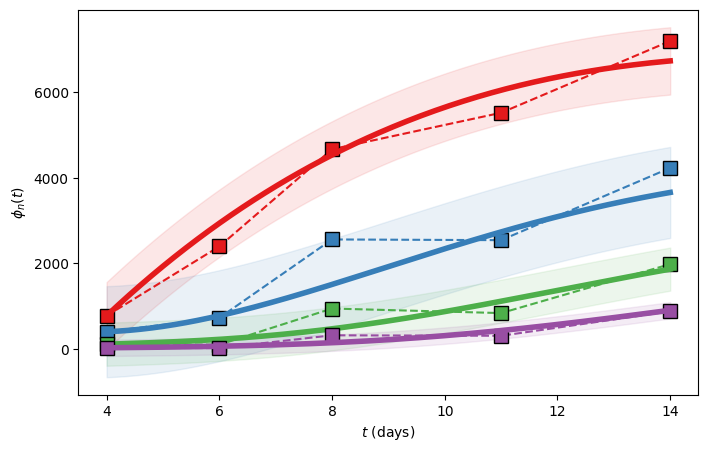

In [59]:
data_sigma_mles = get_sigma_MLEs(
    model=data_model,
    data=data_array,
    mle_params=data_opt_params,
    data_times=data_times,
    noise_model=noise_model
)

plot_mle_solution(
    model=data_model,
    data=data_array,
    data_times=data_times,
    param_mles=data_opt_params,
    sigma_mles=data_sigma_mles,
    max_size_shown=4
)

### Bayesian inference using priors on the noise parameters

In [60]:
data_noise_inferred_log_likelihood = get_log_likelihood(
    problem=data_problem,
    noise_model=noise_model,
    use_profile=False,
    mask_threshold=1
)


model_prior_lower_bounds = data_opt_params / 2.0
model_prior_upper_bounds = data_opt_params * 2.0

model_prior = pints.UniformLogPrior(model_prior_lower_bounds, model_prior_upper_bounds)

sigma_prior_means = data_sigma_mles
sigma_prior_stds = 0.1 * sigma_prior_means

sigma_prior = [
    pints.TruncatedGaussianLogPrior(
        mean=sigma_prior_means[i],
        sd=sigma_prior_stds[i],
        a=0,
        b=np.infty
    )
for i in range(data_model.n_outputs())]

all_priors = [model_prior] + sigma_prior
log_prior = pints.ComposedLogPrior(*all_priors)

initial_mcmc_points = [list(data_opt_params) + list(data_sigma_mles) for _ in range(4)]

data_noise_inferred_chains = get_mcmc_chains(
    log_likelihood=data_noise_inferred_log_likelihood,
    apply_log_transform=True,
    max_mcmc_iterations=10000,
    prior_lower_bounds=None,
    prior_upper_bounds=None,
    specified_log_prior=log_prior,
    initial_mcmc_points=initial_mcmc_points
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0         0          0:00.1
2     12     0         0         0         0          0:00.1
3     16     0         0         0         0          0:00.1
20    84     0         0         0         0          0:00.7
40    164    0         0         0         0          0:01.4
60    244    0         0         0         0          0:02.0
80    324    0         0         0         0          0:02.7
100   404    0         0         0         0          0:03.3
120   484    0         0         0         0          0:04.0
140   564    0         0         0         0          0:04.7
160   644    0         0         0         0          0:05.3
180   724    0         0         0         0          0:06.0
Initial phase completed.
200   804    0         0 

(<Figure size 1200x600 with 6 Axes>,
 array([[<Axes: xlabel='b', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='b'>],
        [<Axes: xlabel='f', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='f'>],
        [<Axes: xlabel='g', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='g'>]], dtype=object))

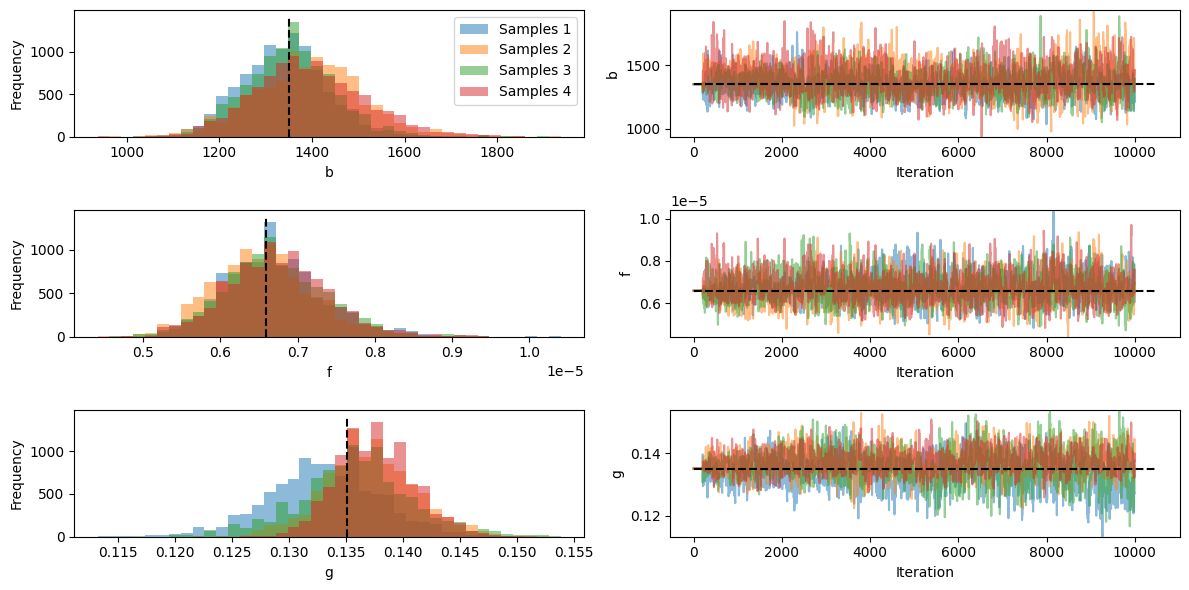

In [61]:
pints.plot.trace(
    data_noise_inferred_chains[:, :, :3],
    parameter_names=data_model.param_names,
    ref_parameters=data_opt_params
)

(<Figure size 900x900 with 9 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >],
        [<Axes: ylabel='f'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='b', ylabel='g'>, <Axes: xlabel='f'>,
         <Axes: xlabel='g'>]], dtype=object))

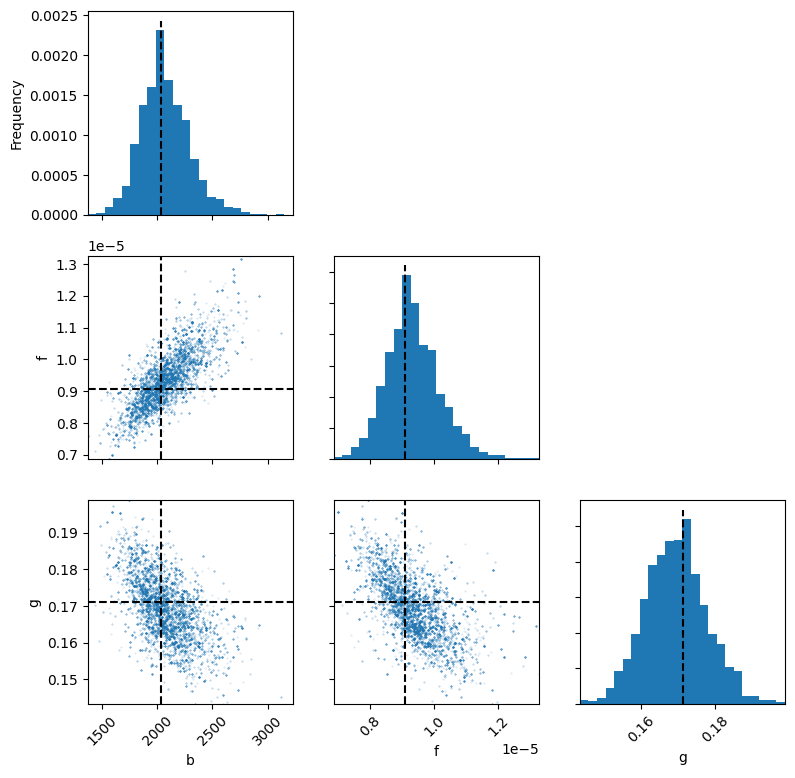

In [35]:
pints.plot.pairwise(
    data_noise_inferred_chains[0, :, :3],
    parameter_names=data_model.param_names,
    ref_parameters=data_opt_params
)

### Bayesian inference using fixed noise parameters

In [36]:
data_noise_fixed_log_likelihood = get_log_likelihood(
    problem=data_problem,
    noise_model=noise_model,
    use_profile=True,
    mask_threshold=1
)


model_prior_lower_bounds = data_opt_params / 2.0
model_prior_upper_bounds = data_opt_params * 2.0

log_prior = pints.UniformLogPrior(model_prior_lower_bounds, model_prior_upper_bounds)


initial_mcmc_points = [list(data_opt_params) for _ in range(4)]

data_noise_fixed_chains = get_mcmc_chains(
    log_likelihood=data_noise_fixed_log_likelihood,
    apply_log_transform=True,
    max_mcmc_iterations=10000,
    prior_lower_bounds=None,
    prior_upper_bounds=None,
    specified_log_prior=log_prior,
    initial_mcmc_points=initial_mcmc_points
)

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0         0          0:00.0
2     12     0         0         0         0          0:00.1
3     16     0         0         0         0          0:00.1
20    84     0.0476    0         0         0.19       0:00.5
40    164    0.0488    0         0.0244    0.146      0:01.1
60    244    0.0656    0.0164    0.0164    0.115      0:01.7
80    324    0.0617    0.0123    0.037     0.123      0:02.1
100   404    0.0495    0.0297    0.0297    0.139      0:02.4
120   484    0.0496    0.0331    0.0248    0.124      0:03.0
140   564    0.0496    0.0426    0.0284    0.106383   0:03.4
160   644    0.0435    0.0435    0.0311    0.0932     0:03.8
180   724    0.0497    0.0718    0.0387    0.0829     0:04.4
Initial phase completed.
200   804    0.0498    0.

(<Figure size 1200x600 with 6 Axes>,
 array([[<Axes: xlabel='b', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='b'>],
        [<Axes: xlabel='f', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='f'>],
        [<Axes: xlabel='g', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='g'>]], dtype=object))

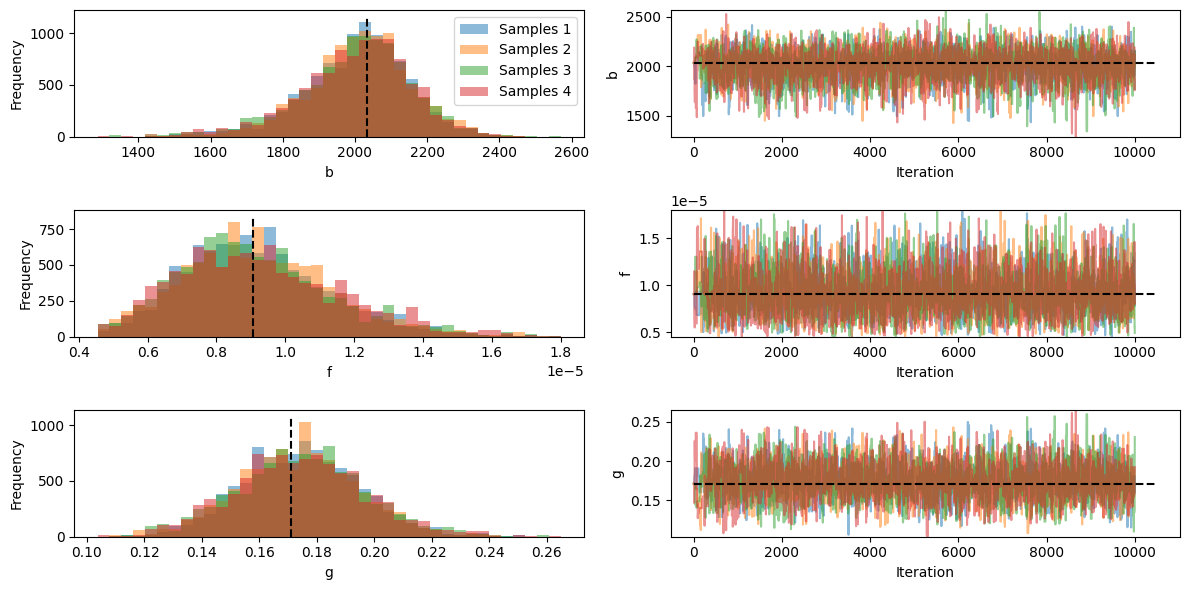

In [37]:
pints.plot.trace(
    data_noise_fixed_chains,
    parameter_names=data_model.param_names,
    ref_parameters=data_opt_params
)

(<Figure size 900x900 with 9 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >],
        [<Axes: ylabel='f'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='b', ylabel='g'>, <Axes: xlabel='f'>,
         <Axes: xlabel='g'>]], dtype=object))

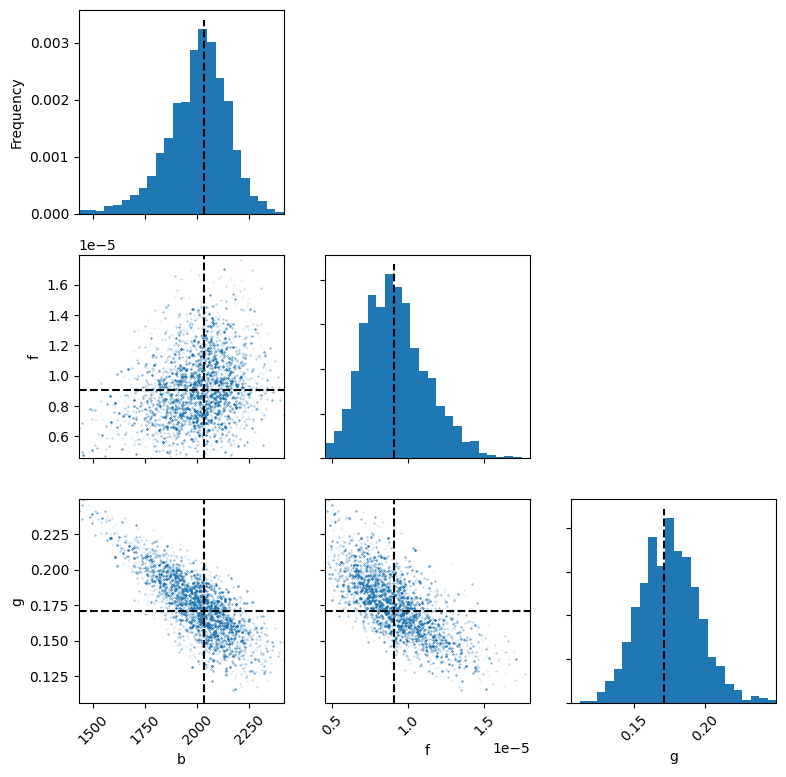

In [38]:
pints.plot.pairwise(
    data_noise_fixed_chains[0],
    parameter_names=data_model.param_names,
    ref_parameters=data_opt_params
)

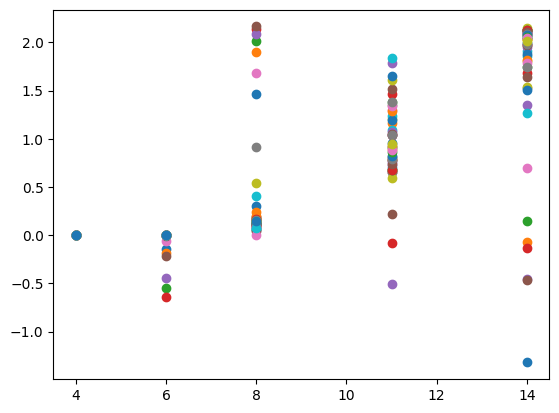

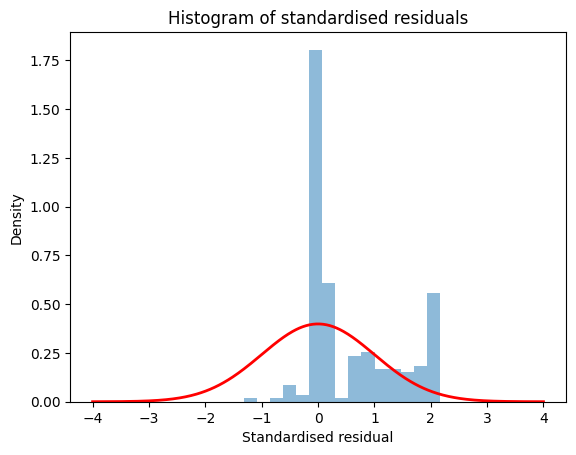

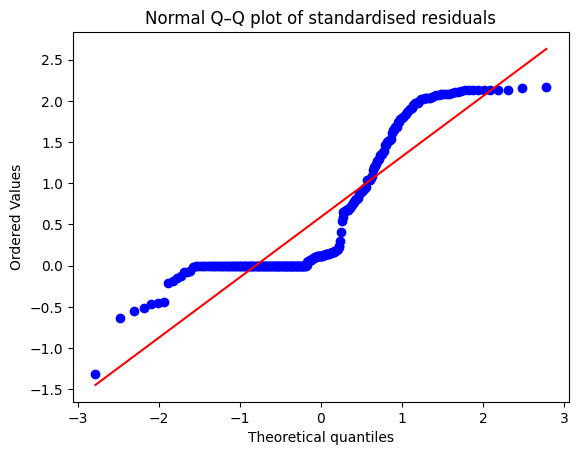

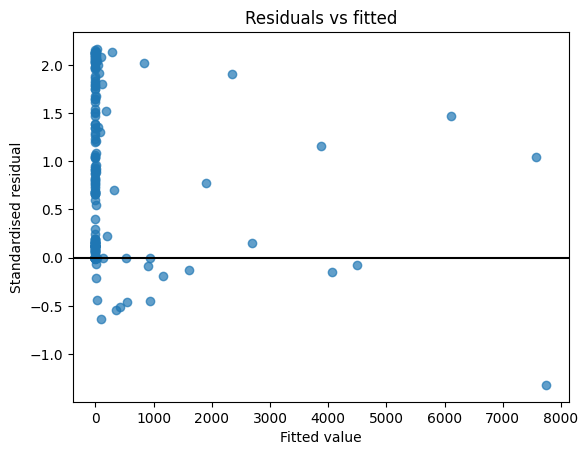

In [53]:
import scipy.stats as st
import matplotlib.pyplot as plt

model_pred = data_model.simulate(data_opt_params, data_times)

std_residuals = get_standardised_residuals(
    model=data_model,
    data=data_array,
    data_times=data_times,
    mle_params=data_opt_params,
    noise_model=noise_model
)

r = std_residuals[np.isfinite(std_residuals)].ravel()

plt.plot(data_times, std_residuals, marker='o', linestyle='')
plt.show()

x = np.linspace(-4, 4, 400)
plt.hist(r, bins=15, density=True, alpha=0.5)
plt.plot(x, st.norm.pdf(x), 'r-', lw=2)
plt.xlabel('Standardised residual')
plt.ylabel('Density')
plt.title('Histogram of standardised residuals')
plt.show()

st.probplot(r, dist="norm", plot=plt)
plt.title("Normal Q–Q plot of standardised residuals")
plt.show()

plt.scatter(model_pred.ravel(), r, alpha=0.7)
plt.axhline(0, color='k')
plt.xlabel('Fitted value')
plt.ylabel('Standardised residual')
plt.title('Residuals vs fitted')
plt.show()

In [50]:
print(st.shapiro(r))

print(st.anderson(r, dist='norm'))


ShapiroResult(statistic=0.8107307575749165, pvalue=6.406747002495253e-17)
AndersonResult(statistic=22.101687661505878, critical_values=array([0.567, 0.646, 0.775, 0.904, 1.076]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.5916202750082263, scale=0.8078022332443879)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


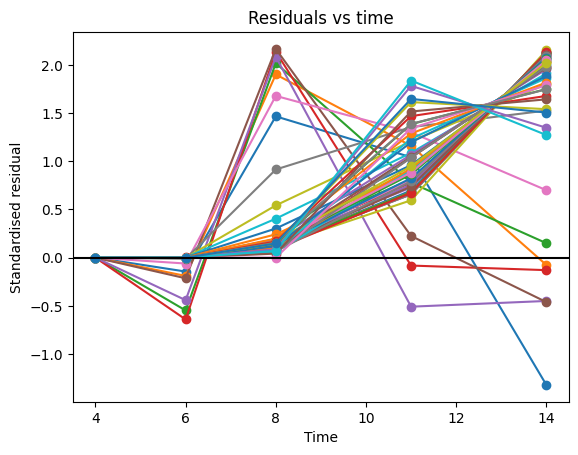

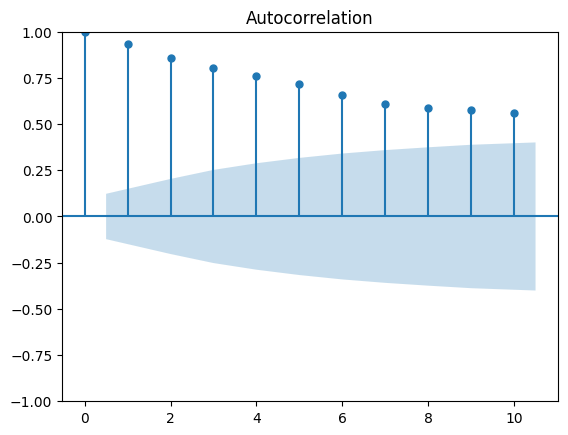

In [47]:
plt.plot(data_times, std_residuals, 'o-')
plt.axhline(0, color='k')
plt.xlabel('Time')
plt.ylabel('Standardised residual')
plt.title('Residuals vs time')
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(r, lags=min(10, len(r)//2))
plt.show()

In [49]:
from scipy.stats import t
loglik = np.sum(t.logpdf(std_residuals, df=5) - np.log(data_sigma_mles))
print(loglik)

-416.85192179491514
